# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from dtw import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

In [3]:
def display_distance_matrix_as_table(
    distance_matrix, labels=None, figsize=(8, 2)
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("tight")
    ax.axis("off")
    norm = mpl.colors.Normalize()
    cell_colours_hex = np.empty(shape=distance_matrix.shape, dtype=object)
    cell_colours_rgba = plt.get_cmap("magma")(norm(distance_matrix))

    for i in range(distance_matrix.shape[0]):
        for j in range(i + 1, distance_matrix.shape[0]):
            cell_colours_hex[i, j] = rgb2hex(
                cell_colours_rgba[i, j], keep_alpha=True
            )
            cell_colours_hex[j, i] = cell_colours_hex[i, j]

    if labels is not None:
        _ = ax.table(
            cellText=distance_matrix,
            colLabels=labels,
            rowLabels=labels,
            loc="center",
            cellColours=cell_colours_hex,
        )
    else:
        _ = ax.table(
            cellText=distance_matrix,
            loc="center",
            cellColours=cell_colours_hex,
        )

    return ax

# Spectral feature

## Question 6

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def get_auto_covariances(X, N, tau):
    """
    This function calculates the autocovariance of a time series X for a given lag tau.
    The autocovariance is normalized by the length of the time series N.
    """
    if tau >= 0:
        return (1/N)*np.sum(X[:N-tau]*X[tau:])
    else:
        tau = -tau
        return (1/N)*np.sum(X[tau:]*X[:N-tau])

def plot_average_autocovariances_with_std(N, nb_simulations):
    """
    This function plots the average autocovariances of a Gaussian noise time series with variance 1 and sampling frequency 1.
    The autocovariances are calculated for lags ranging from -N+1 to N-1.
    The function also plots the standard deviation of the autocovariances.
    """
    tau = np.arange(-N+1, N)
    sample_autocovariances = np.zeros((2*N-1, nb_simulations)) # pre-allocation

    for i in np.arange(nb_simulations):
        X = np.random.randn(N)
        for j in np.arange(2*N-1):
            sample_autocovariances[j, i] = get_auto_covariances(X, N, tau[j])

    mean = np.mean(sample_autocovariances, axis=1)
    std = np.std(sample_autocovariances, axis=1)

    plt.plot(tau, mean, 'k-')
    plt.fill_between(tau, mean-std, mean+std, alpha=0.5, label='standard deviation')
    plt.xlabel('τ')
    plt.ylabel('mean autocovariances')
    plt.grid()
    plt.show()

def plot_average_periodogram_with_std(N, nb_simulations):
    """
    This function plots the average periodogram of a Gaussian noise time series with variance 1 and sampling frequency 1.
    The periodogram is calculated for frequencies ranging from 0 to N/2.
    The function also plots the standard deviation of the periodogram.
    """
    k = np.arange(N//2+1) # K ranging from 0 to N/2
    fk = k / N # fk = fs * k / N, fs = 1
    cos = np.cos(2*np.pi * np.outer(k, np.arange(N))/N) 
    cos[:,1:] *= 2
    periodograms = np.zeros((len(k), nb_simulations))

    for i in range(nb_simulations):
        X = np.random.randn(N)
        autocovariances = np.zeros((N, nb_simulations))
        for j in range(N-1):
            autocovariances[j] = get_auto_covariances(X, N, j)
        periodograms[:, i] = np.sum(autocovariances[:, i]* cos, axis=1)
    
    mean = np.mean(periodograms, axis=1)
    std = np.std(periodograms, axis=1)

    plt.plot(fk, mean, 'k-')
    plt.fill_between(fk, mean-std, mean+std, alpha=0.5, label='standard deviation')
    plt.xlabel('f_k')
    plt.ylabel('mean periodogram')
    plt.grid()
    plt.show()


## Working implementation using the FFT
# def plot_average_periodogram_with_std(N, nb_simulations):
#     fk = np.arange(N//2+1) / N
#     periodograms = np.zeros((N//2+1, nb_simulations)) # pre-allocation
# 
#     for i in range(nb_simulations):
#         X = np.random.randn(N)
#         fft_X = np.fft.fft(X)
#         periodograms[:, i] = np.abs(fft_X[:N//2+1])**2 / N
# 
#     mean = np.mean(periodograms, axis=1)
#     std = np.std(periodograms, axis=1)
# 
#     plt.plot(fk, mean, 'k-')
#     plt.fill_between(fk, mean-std, mean+std, alpha=0.5, label='standard deviation')
#     plt.xlabel('f_k')
#     plt.ylabel('mean periodogram')
#     plt.grid()
#     plt.show()
# 


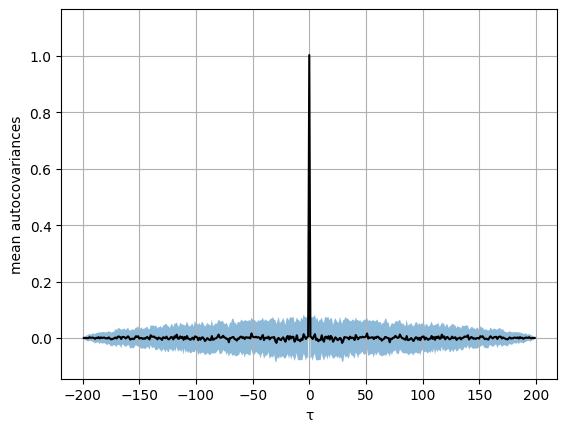

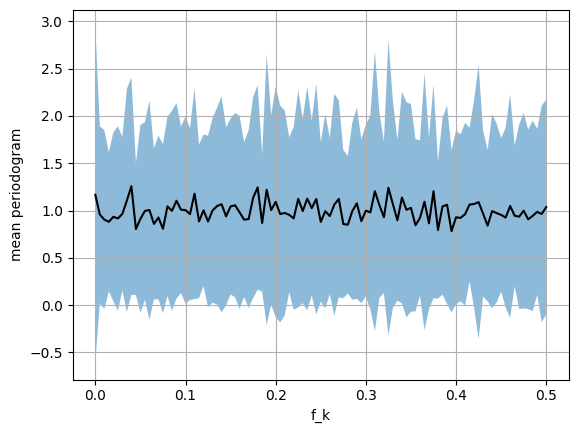

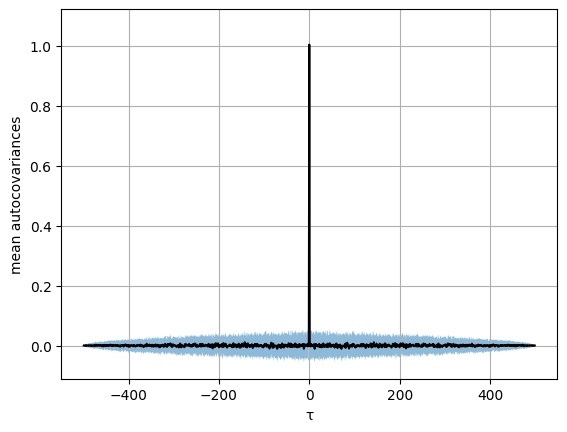

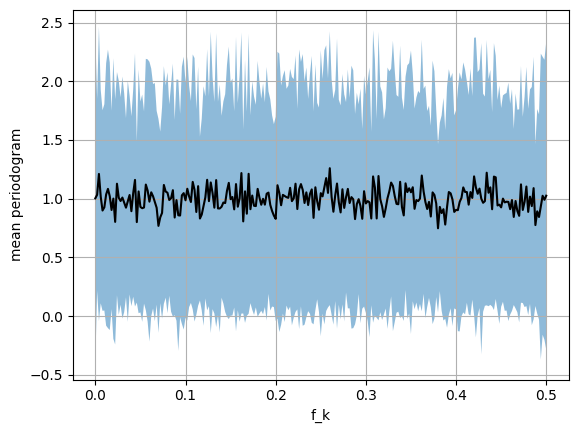

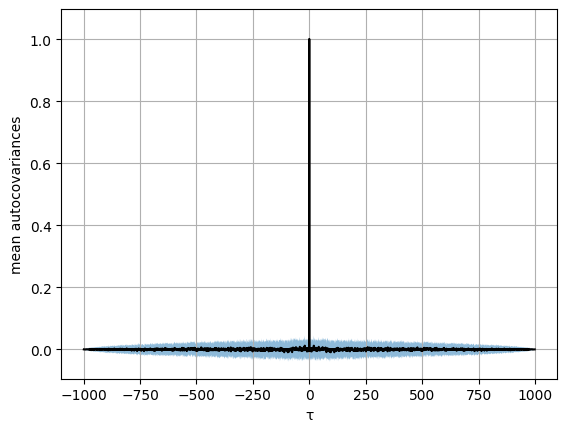

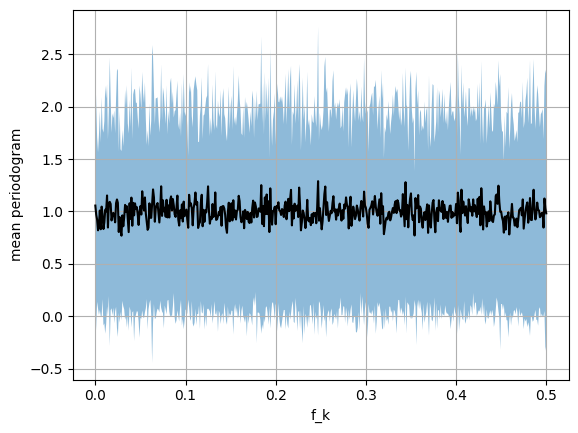

In [5]:
N = [200, 500, 1000]
nb_simulations = 100

for n in N:
    plot_average_autocovariances_with_std(n, nb_simulations)
    plot_average_periodogram_with_std(n, nb_simulations)

## Question 9

In [6]:
def plot_average_periodogram_with_std_barlett(N, nb_simulations, K=5):
    """
    This function plots the average periodogram of a Gaussian noise time series with variance 1 and sampling frequency 1.
    The periodogram is calculated using Bartlett's method, which involves dividing the time series into K sections and averaging the periodograms of each section.
    The function also plots the standard deviation of the periodogram.
    """
    
    M = N // K  # Length of each section

    # K ranging from 0 to M/2
    k = np.arange(M//2+1)

    # fk = fs * k / M, fs = 1
    fk = k / M
    tau = np.arange(M)
    cos = np.cos(2*np.pi * np.outer(k, np.arange(M))/M) 
    cos[:,1:] *= 2
    periodograms = np.zeros((len(k), nb_simulations))

    for i in range(nb_simulations):
        X = np.random.randn(N)
        periodogram_sections = np.zeros((len(k), K))
        for section in range(K):
            X_section = X[section*M:(section+1)*M]
            autocovariances = [get_auto_covariances(X_section, M, t) for t in tau]
            periodogram_sections[:, section] = np.sum(autocovariances * cos, axis=1)
        periodograms[:, i] = np.mean(periodogram_sections, axis=1)
    
    mean = np.mean(periodograms, axis=1)
    std = np.std(periodograms, axis=1)

    plt.plot(fk, mean, 'k-')
    plt.fill_between(fk, mean-std, mean+std, alpha=0.5, label='standard deviation')
    plt.xlabel('f_k')
    plt.ylabel('mean periodogram')
    plt.grid()
    plt.show()

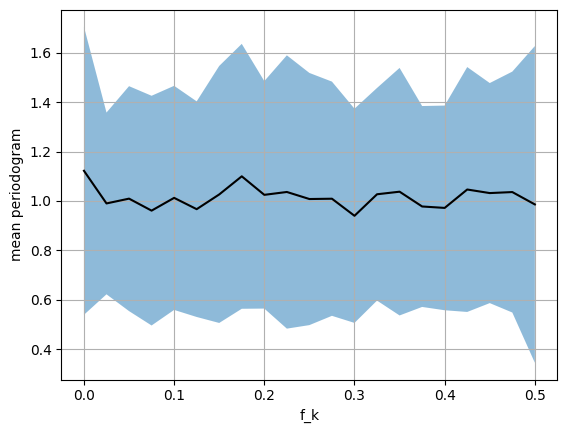

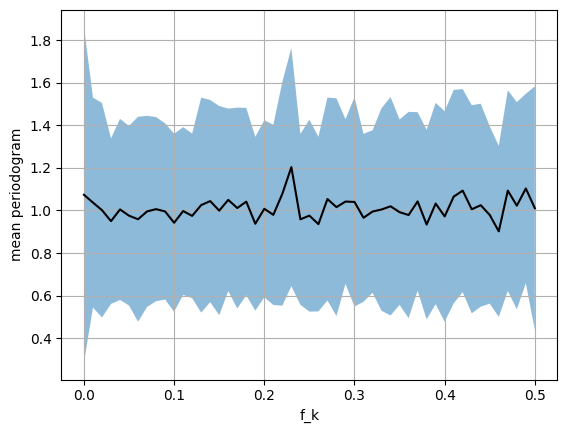

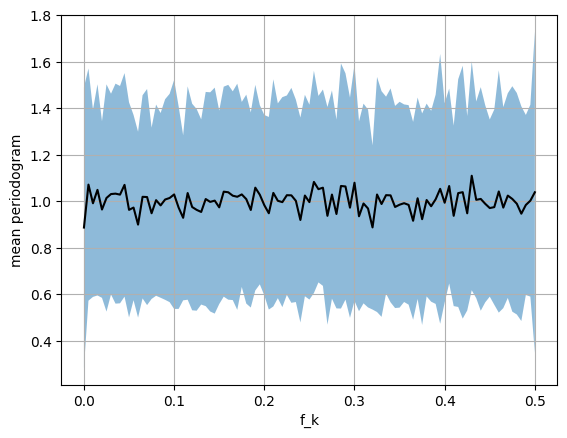

In [7]:
plot_average_periodogram_with_std_barlett(200, 100, 5)
plot_average_periodogram_with_std_barlett(500, 100, 5)
plot_average_periodogram_with_std_barlett(1000, 100, 5)

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [8]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

Let us start by looking at what the dataset looks like.

Training dataset size: 168
Test dataset size: 88
Range of lengths for steps in the training dataset: 32 to 99 samples.
An example of 2 steps, one healthy and one non-healthy:


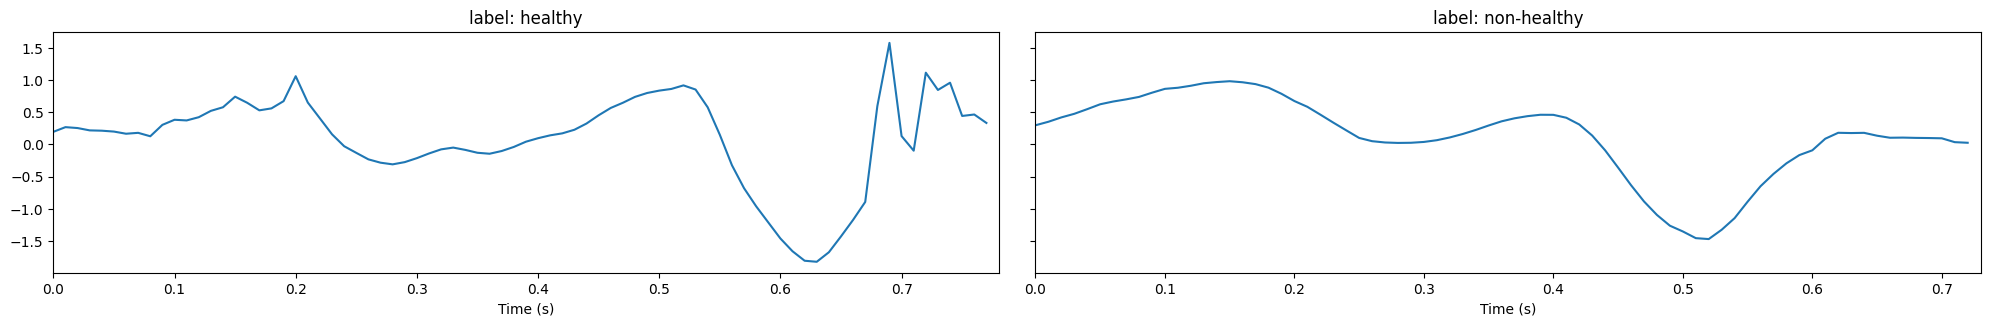

In [5]:
print("Training dataset size:", len(X_train))
print("Test dataset size:", len(X_test))
print("Range of lengths for steps in the training dataset:", min([step.size for step in X_train]), "to", max([step.size for step in X_train]), "samples.")
print("An example of 2 steps, one healthy and one non-healthy:")
FREQUENCY = 100
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
for ind, ax in zip([1, 16], ax_arr):
    s = X_train[ind]
    tt = np.arange(s.size) / FREQUENCY
    ax.plot(tt, s)
    ax.set_xlim(0, s.size / FREQUENCY)
    ax.set_xlabel("Time (s)")
    label = ["healthy", "non-healthy"][y_train[ind]]
    _ = ax.set_title(f"label: {label}")

Let us check how good the DTW distance is at differentiating steps of different classes.

In [6]:
# Define dtw distance function
def get_dtw_distance(signal_1, signal_2):
    return dtw(signal_1, signal_2, keep_internals=False).distance

In [7]:
# Compute the DTW-distance matrix
X_train_distance_matrix = np.zeros(
    (len(X_train), len(X_train)), dtype=float
)

for row in range(len(X_train)):
    for col in range(row + 1, len(X_train)):
        X_train_distance_matrix[row, col] = get_dtw_distance(X_train[row], X_train[col])
        X_train_distance_matrix[col, row] = X_train_distance_matrix[row, col]

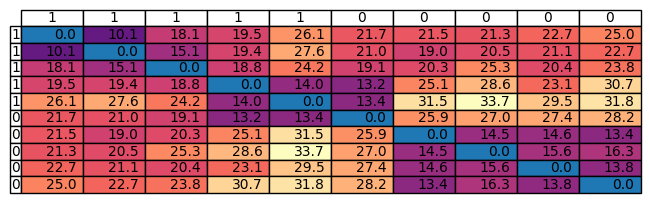

In [8]:
_ = display_distance_matrix_as_table(
    np.round(X_train_distance_matrix[87:97, 87:97], 1), labels=y_train[87:97]
)

Intra-class distances tend to be smaller than extra-class distances, although classes are more difficult to distinguish for some steps (for example, steps at positions 4 and 5 starting from 0 on this table. Step number 5 actually looks closer to steps of the opposite class). The classifying task will not be trivial.

Let us now train a K-NN classifier using the DTW distance.

We will use the K-neighbors classifier implemented in _scikit-learn_. To avoid problems related to the fact that matrix $X$ is jagged (different steps may have different lengths), which _scikit-learn_ is not suited for, we use a `precomputed` metric. This forces us to use a pre-computed distance-matrix as the one displayed above.

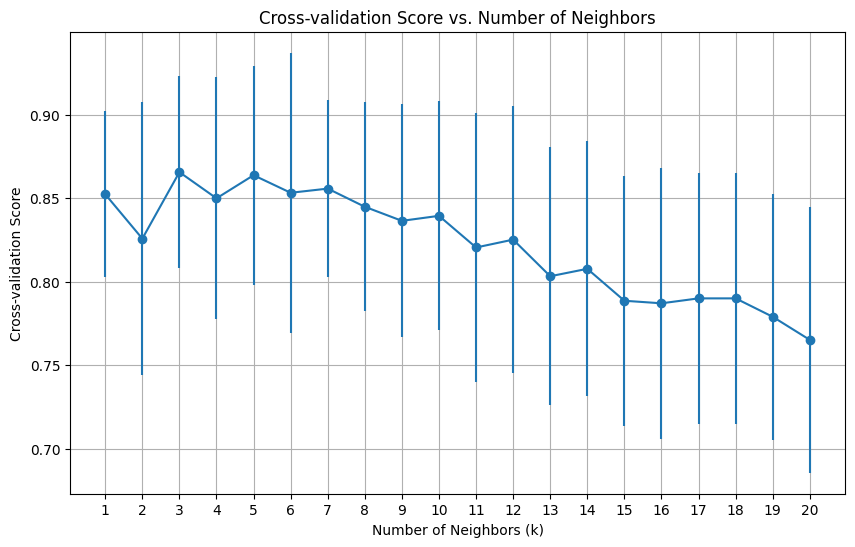

In [24]:
# Range of k values to test
k_values = np.arange(1, 21, 1)

# Perform 5-fold cross-validation for each k
mean_scores = []
std_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
    cv_scores = cross_val_score(knn, X_train_distance_matrix, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=20), scoring='f1')
    
    # Calculate and store the mean and standard deviation of cross-validation scores
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    mean_scores.append(mean_score)
    std_scores.append(std_score)
mean_scores = np.array(mean_scores)
std_scores = np.array(std_scores)

# Plot the cross-validation score vs. number of neighbors with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='o-')
plt.title('Cross-validation Score vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-validation Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [10]:
print("Best F-score from cross-validation:", np.max(mean_scores))

Best F-score from cross-validation: 0.8655303030303031


We will keep a number of neighbors $k=3$, associated to an F-score of $0.87$.

In [11]:
# Train the classifier on the whole training dataset with the chosen parameter
knn = KNeighborsClassifier(n_neighbors=3, metric="precomputed")
knn.fit(X_train_distance_matrix, y_train)

KNeighborsClassifier(metric='precomputed', n_neighbors=3)

In [12]:
# To use a "precomputed metric", we have to precompute the distance of each test step versus all training steps indexed in the trained k-NN
eval_distance_matrix = np.zeros(
    (len(X_test), len(X_train)), dtype=float
)

for row in range(len(X_test)):
    for col in range(len(X_train)):
        eval_distance_matrix[row, col] = get_dtw_distance(X_test[row], X_train[col])

In [13]:
# Evaluate the final classifier on the test set
print("Final accuracy:", knn.score(eval_distance_matrix, y_test))
y_pred = knn.predict(eval_distance_matrix)
print("Final F-score:", f1_score(y_test, y_pred))

Final accuracy: 0.3409090909090909
Final F-score: 0.48214285714285715


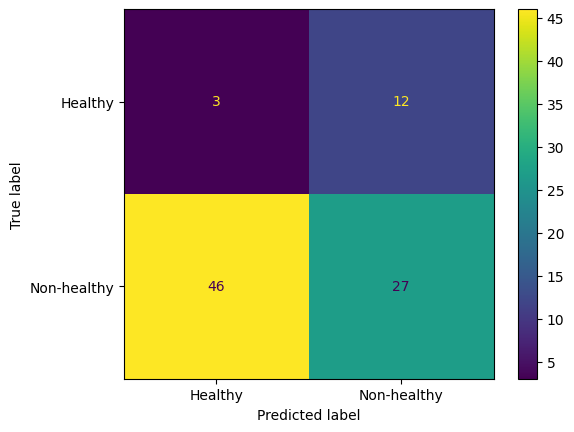

In [15]:
# Plot confusion matrix
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Healthy', 'Non-healthy'])

The classifier performs much worse than on the training set, and actually worse than a random classifier.

This may be due to a classifier that does not generalize well and to a test set that is fairly different from the training set; in particular, the test set seems to contain a majority of non-healthy patients.

## Question 11

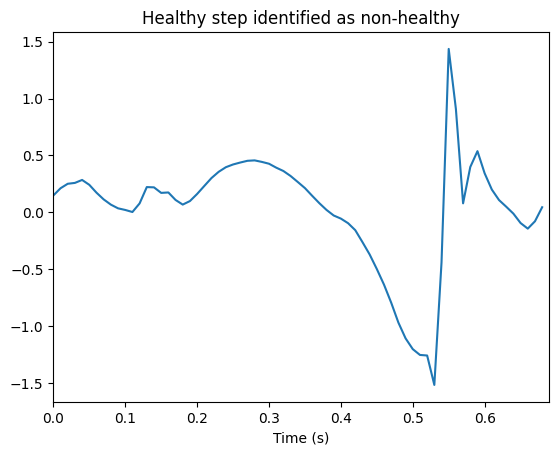

In [76]:
# Plot a badly identified healthy step
index = np.argmax(np.logical_and((np.logical_not(y_pred) == y_test), (np.logical_not(y_test))))
print("Index number:", index)
s = X_test[index]
tt = np.arange(s.size) / FREQUENCY
plt.plot(tt, s)
plt.xlim(0, s.size / FREQUENCY)
plt.xlabel("Time (s)")
plt.title("Healthy step identified as non-healthy")
plt.show()

Index number: 0


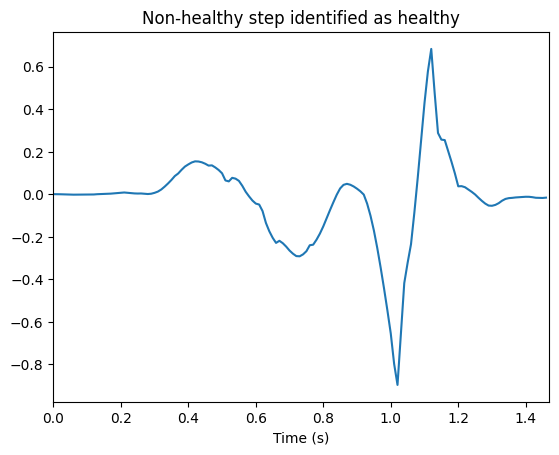

In [79]:
# Plot a badly identified non-healthy step
index = np.argmax(np.logical_and((np.logical_not(y_pred) == y_test), (y_test)))
print("Index number:", index)
s = X_test[index]
tt = np.arange(s.size) / FREQUENCY
plt.plot(tt, s)
plt.xlim(0, s.size / FREQUENCY)
plt.xlabel("Time (s)")
plt.title("Non-healthy step identified as healthy")
plt.show()